# Task 1

Task №1

X,Y are a Rundom Variables taken from Normal Distribution: X\~N(e1,q1^2) , Y\~N(e2,q2^2)

corr(X,Y) = p

S = aX+bY (a and b - const)

(a+b = 1 , 0<=a<=1, 0<=b<=1 ) 

What 'a' and 'b' should be chosen in order to minimise var[S] ?

Write analytical AND numerical solutions to this problem using Jupyter Notebook

## Import libs and define vars

In [619]:
from operator import itemgetter
import math
import numpy as np

import matplotlib.pyplot as plt

from sympy import diff, sin, exp, pycode
from sympy.abc import x,y 
from scipy.misc import derivative
from sympy.solvers import solve


In [577]:
np.random.seed(100)
e1 = 0
e2 = 1
q1 = 0.01
q2 = 0.05
X = np.random.normal(loc=e1, scale=q1, size=1000)
Y = np.random.normal(loc=e2, scale=q2, size=1000)

## Numerical solution

In [578]:
arr = []
for a in np.linspace(0,1,100000):
    b = 1-a
    arr.append((a,b,np.var(a * X + b * Y)))

In [580]:
a, b, minimized_variance = min(arr, key=itemgetter(2))
print(f"a, b, and minimized variance are equal to: {a}, {b}, {minimized_variance}")

a, b, and minimized variance are equal to: 0.9577495774957749, 0.04225042250422506, 0.00010465434040723303


### Plot values to see if we correctly found min variance

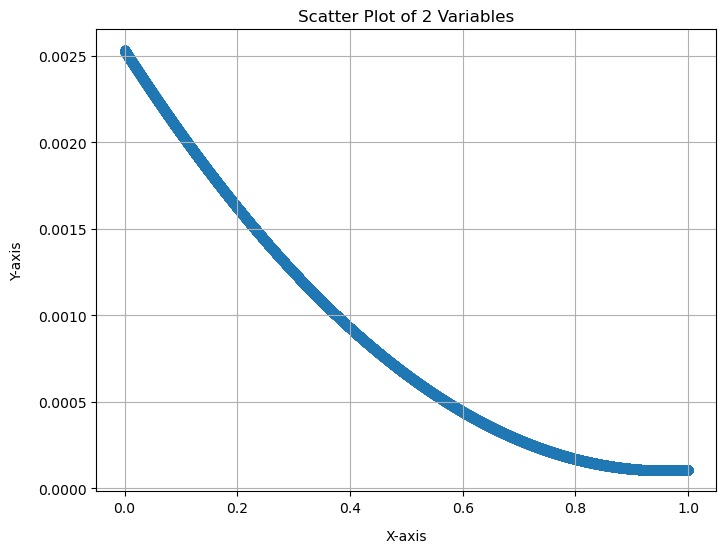

In [581]:
a_values, b_values, var_values = zip(*arr)

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
# Add labels and title
plt.xlabel("X-axis", labelpad=10)
plt.ylabel("Y-axis", labelpad=10)
plt.title("Scatter Plot of 2 Variables")
plt.grid(True)
plt.scatter(a_values, var_values)
# Show the plot
plt.show()


### Zoom in, by filtering close to found value

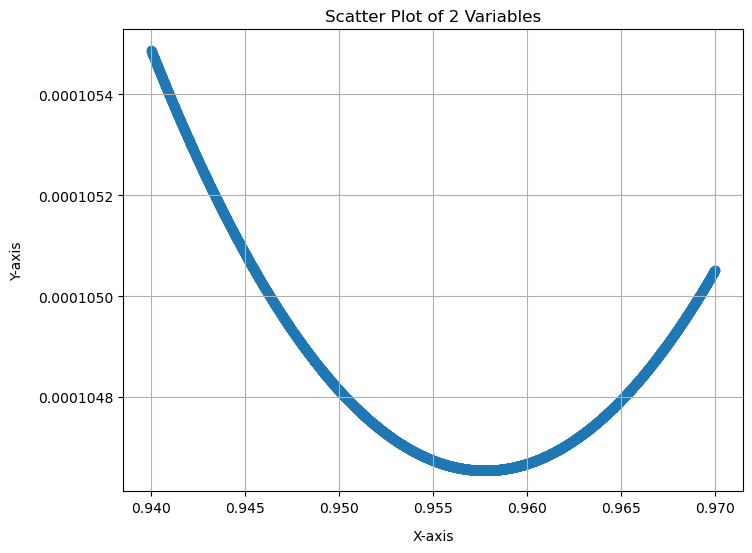

In [582]:
data = [element for element in arr if element[0] > 0.94 and element[0] < 0.97]
a_values, b_values, var_values = zip(*data)

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
# Add labels and title
plt.xlabel("X-axis", labelpad=10)
plt.ylabel("Y-axis", labelpad=10)
plt.title("Scatter Plot of 2 Variables")
plt.grid(True)
plt.scatter(a_values, var_values)
# Show the plot
plt.show()


## Analytical solution

In [317]:
def f(a):
    covariance_analytics = p * np.sqrt(q1**2 * q2**2)
    variance_1_analytics = (a**2 * q1**2)
    variance_2_analytics = ((1-a)**2 * q2**2)
    variance_sum_analytics = variance_1_analytics + variance_2_analytics + 2 * a * (1-a) * covariance_analytics
    return variance_sum_analytics

### Let's find each part derivatives

In [584]:
variance_1_analytics = diff("q1^2*a^2", "a")
variance_2_analytics = diff("q2^2*(1-a)^2", "a")
covariance_analytics = diff("2*a*(1-a)*p*(q1^2 * q2^2)^0.5", "a")

### Using solve function we can get analytical solution for portfolio optimization task

In [623]:
a_minimized_expr = solve(variance_1_analytics + variance_2_analytics + covariance_analytics, "a")[0]
a_min = eval(pycode(a_minimized_expr))
b_min = 1 - a_min
minimized_variance = np.var(a_min*X+(1-a_min)*Y)
print(f"a, b, and minimized variance are equal to: {a_min}, {b_min}, {minimized_variance}")

a, b, and minimized variance are equal to: 0.9607169723020818, 0.03928302769791825, 0.00010467764147414331


# Task 2

Write a Monte-Carlo Algorithm for price simulation

Option parameters:
- Strike = 1000
- Implied Volatility = 0.3
- Time to Expiration = Half a Year
- interest rate = 0

Monte-Carlo parameters:
- Start Spot price = 1000
- Realised Volatility = 0.2
- Number of Paths = 50000
- Number of Steps = N days untill the expiration

Use the generated paths for numerical pricing of option using Delta Hedging (ignorring the commisions) and estimate the PNL from purchasing the above option and Delta Hedging it untill the expiration at each step of the path.
The final solution should include generated paths, PNL and time of execution of the above procedures, all of which should be in one cell.

P.S Prioritize the correctnes of the calculations over speed, but the faster the algo the better. 



In [321]:
import numpy as np
from scipy.stats import norm


In [423]:
interest_rate = 0.00
year_days = 252
n_days = round(year_days / 2)
mean_value = interest_rate / year_days
sigma_value = 0.2 / sqrt(year_days)
num_paths = 50000
paths = np.random.lognormal(mean_value, sigma_value, (num_paths, n_days))

In [430]:
np.cumprod(paths, axis = 1).shape

(50000, 125)

## Define functions for BS option price and delta

In [351]:
def bs_option(S0: float, strike: float, T: float, sigma: float, option_type: str = 'call', r: float = 0.0) -> float:
    d1 = (np.log(S0/strike) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S0 * norm.cdf(d1) - strike * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return strike * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError('Option type must be either "call" or "put"')

### Check for put-call parity

In [341]:
S0 = 1000
strike = 1050
T = 1
r = 0.0
sigma = 0.2
call = bs_option(S0, strike, T, sigma, 'call', r)
put = bs_option(S0, strike, T, sigma, 'put', r)

assert abs(call - put - (S0 - strike * np.exp(-r * T))) < 10e-20

In [332]:
def bs_delta(S0: float, strike: float, T: float, sigma: float, option_type: str = 'call', r: float = 0.0) -> float:
    d1 = (np.log(S0/strike) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        return norm.cdf(d1)
    elif option_type == 'put':
        return norm.cdf(d1) - 1
    else:
        raise ValueError('Option type must be either "call" or "put"')

### Check for deltas

In [342]:
S0 = 1000
strike = 800
T = 1
r = 0.00
sigma = 0.2

call_delta = bs_delta(S0, strike, T, sigma, 'call', r)
put_delta = bs_delta(S0, strike, T, sigma, 'put', r)

print(call_delta)
print(put_delta)
assert abs(call_delta - put_delta - 1) < 10e-20

0.887953771183615
-0.11204622881638504


## Main part

In [453]:
portfolio

array([[ 1.46372169e+002,  1.46372169e+002,  1.46372169e+002, ...,
         1.46372169e+002,  1.46372169e+002,  1.46372169e+002],
       [-1.44844479e+002, -4.29392622e+002,  1.49725116e+002, ...,
         5.19271692e+001,  2.20020420e+001,  4.82789263e+001],
       [ 2.05420185e-002, -3.51267936e+003,  4.23644267e+001, ...,
         1.46854571e+002,  2.06255587e+000, -1.06193357e+003],
       ...,
       [-4.92380283e+002,  6.80862312e-202,  0.00000000e+000, ...,
         0.00000000e+000, -1.12963773e+004,  0.00000000e+000],
       [ 1.11604985e-040,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000, -1.01163787e+004,  0.00000000e+000],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         0.00000000e+000, -9.36652105e+003,  0.00000000e+000]])

In [561]:
from time import time

start = time()
year_days = 252
S0 = 1000
strike = 1000
r = 0.0
sigma_daily = 0.2 / np.sqrt(year_days)
sigma = 0.2
T = 0.5
n_days = round(T * year_days)
num_paths = 50000
dt = T/n_days
# Generate the brownian path
# stock_paths = S0 * np.cumprod(1+np.random.normal(mean_value, sigma_value, (n_days, num_paths)), axis = 0)
stock_paths = S0 * np.cumprod(np.random.lognormal(mean_value, sigma_value, (n_days, num_paths)), axis = 0)

# Generate the initial option price
option_price = bs_option(S0, strike, T, sigma, 'call', r)

# Generate the initial delta
delta = bs_delta(S0, strike, T, sigma, 'call', r)

# Generate the cash account
cash = np.zeros(stock_paths.shape)

# Generate the portfolio value
portfolio = np.zeros(stock_paths.shape)

# PnL
pnl = np.zeros(stock_paths.shape)

option_path = np.zeros(stock_paths.shape)
option_delta = np.zeros(stock_paths.shape)

# initial cash is the option price * 100 - delta * S0
cash[0] = option_price * 100 - 100 * delta * S0

# initial portfolio value is the - option price * 100 + delta * S0
portfolio[0] = - option_price * 100 + 100 * delta * S0

option_path[0] = option_price
option_delta[0] = delta

for t in range(1, n_days):
    # Update the stock price
    stock_price = stock_paths[t]

    # Update the option price
    option_price = bs_option(stock_price, strike, T - t * dt, sigma, 'call', r)
    option_path[t] = option_price

    # Update the delta
    delta = bs_delta(stock_price, strike, T - t * dt, sigma, 'call', r)
    option_delta[t] = delta

    # Update the portfolio value
    portfolio[t] = - option_price * 100 + 100 * delta * stock_price

    # Update the cash account
    cash[t] = cash[t-1] - 100 * (delta - option_delta[t-1]) * stock_price

    # Update the PnL
    pnl[t] = portfolio[t] + cash[t]

end = time()


In [548]:
print(f"Time to exec: {end-start} seconds")
print(f"Estimated PnL is: {pnl[-1].mean()}")
stock_paths


Time to exec: 0.7737889289855957 seconds
Estimated PnL is: -46.27886563681182


array([[1014.39361716,  988.12928263,  996.69396108, ...,  993.69151965,
        1003.36861677,  979.00177444],
       [1025.73956746,  984.23541748, 1006.06369809, ...,  993.78280183,
        1016.42380003,  976.13295485],
       [1012.60126211,  987.94063708,  980.31297594, ...,  984.23636376,
        1007.48335888,  964.62174513],
       ...,
       [ 932.85727209,  924.03530729,  721.83167028, ..., 1199.54340712,
        1129.80898461,  771.95515327],
       [ 924.13768949,  910.81543712,  721.27731756, ..., 1223.99328748,
        1119.95442374,  788.73731442],
       [ 919.22136167,  902.96018983,  728.00940229, ..., 1209.21344075,
        1117.10930698,  785.26865067]])

### Few charts

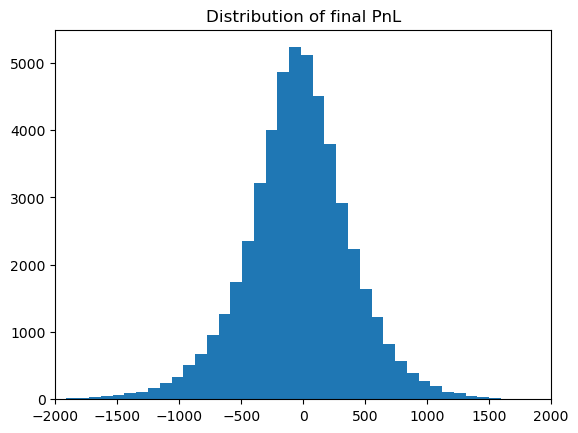

In [562]:
# check distribution of final PnL
plt.hist(pnl[-1], bins=50)
plt.title('Distribution of final PnL')
plt.xlim(-2000, 2000)
plt.show()

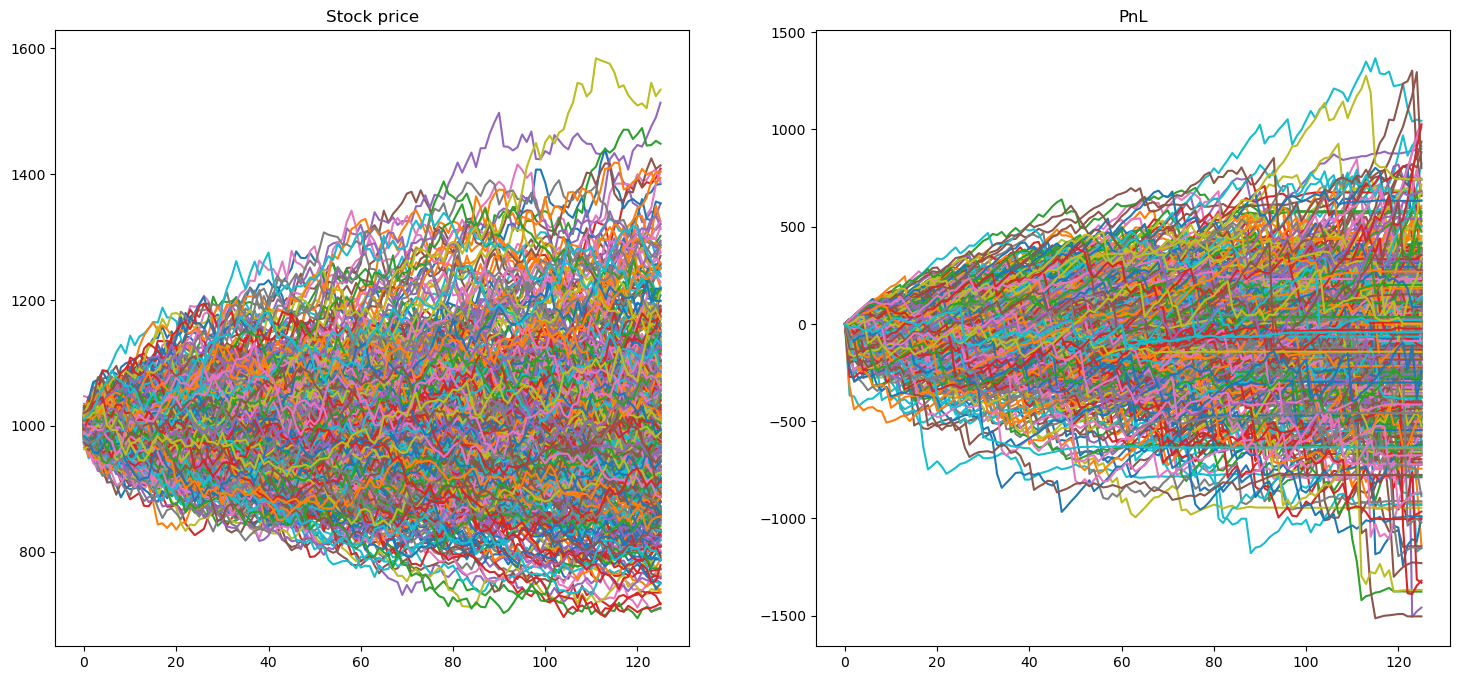

In [560]:
# Plot the PnL vs Stock price but only for 500 paths
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

ax[0].plot(stock_paths)
ax[0].set_title('Stock price')

ax[1].plot(pnl)
ax[1].set_title('PnL')

plt.show()


# Task 3

You are given random variables from a Normal Distribution : X~N(mu,s), mu= 0 , s - ?

Suppose that random variables are equivalent to daily log-returns of the stock

Mean Average Deviation of X = 1%

what is the yearly Standard Deviation of X ?

## Define vars

In [627]:
daily_mean_absolute_deviation = 0.01
year_days = 252

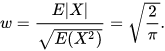

## Main solution

In [568]:
daily_std = np.sqrt(np.pi/2) * daily_mean_absolute_deviation
yearly_std = np.sqrt(year_days) * daily_std

In [626]:
print(f"Yearly Standard Deviation of X is: {round(100*yearly_std,4)}%")

Yearly Standard Deviation of X is: 19.8957%
